## 일변량 비선형 변환
* 트리 기반 모델은 특성의 순서에만 영향을 받지만 선형 모델과 신경망은 각 특성의 스케일과 분포에 밀접하게 연관.
* 특성과 타깃 값 사이에 비선형성이 있다면 특히 선형 회귀에서는 모델을 만들기가 어렵다.
* log와 exp 함수는 데이터의 스케일을 변경해 선형 모델과 신경망의 성능을 올리는 데 도움을 준다.
* 대부분의 모델은 각 특성이 정규분포와 비슷할 때 최고의 성능을 낸다.

In [1]:
import numpy as np

rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)
print(X[:10, 0])

[ 56  81  25  20  27  18  12  21 109   7]


In [2]:
print('feature:\n{}'.format(np.bincount(X[:, 0])))

feature:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


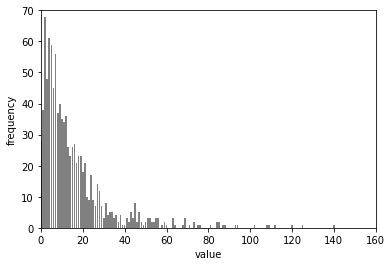

In [3]:
import matplotlib.pyplot as plt

plt.xlim(0, 160)
plt.ylim(0, 70)
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='grey')
plt.ylabel('frequency')
plt.xlabel('value')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print(f'test score: {score:.4f}')

test score: 0.6224


In [5]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

Text(0.5, 0, 'value')

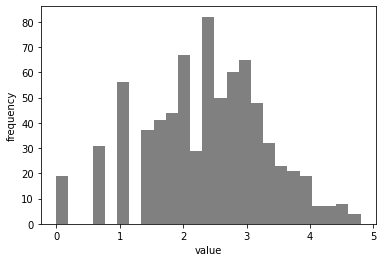

In [6]:
plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel('frequency')
plt.xlabel('value')

In [7]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print(f'test score: {score:.4f}')

test score: 0.8749


* 일부 특성만 변환하거나 특성마다 모두 다르게 변환하기도 한다.
* 이런 변환은 트리 기반 모델에서는 불필요하지만 선형 모델에서는 필수.
* 가끔 회귀에서 타깃 변수 y를 변환하는 것이 좋을 때도 있다.

## 특성 자동 선택
* 일변량 통계 (univariate statistics)
* 모델 기반 선택 (model-based selection)
* 반복적 선택 (iterative selection)

### 일변량 통계
* 개개의 특성과 타깃 사이에 중요한 통계적 관계가 있는지를 계산.
* 각 특성이 독릴적으로 평가된다는 점.
* 다른 특성과 깊게 연관된 특성은 선택되지 않을 것.
* 계산이 매우 빠르고 평가를 위해 모델을 만들 필요가 없다.
* 특성은 선택한 후 적용하려는 모델에 상관없이 사용할 수 있다.
* f_classif, f_regression
    * p-값(p-value)에 기초하여 특성을 제외하는 방식.

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5
)

select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print('X_train.shape:', X_train.shape)
print('X_train_selected.shape:', X_train_selected.shape)

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([<matplotlib.axis.YTick at 0x1f72b64d5e0>], [Text(0, 0, '')])

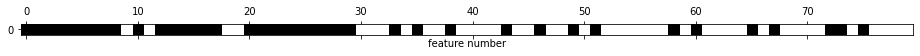

In [10]:
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('feature number')
plt.yticks([0])

In [12]:
from sklearn.linear_model import LogisticRegression

X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
print(f'all features score: {lr.score(X_test, y_test)}')
lr.fit(X_train_selected, y_train)
print(f'selected features score: {lr.score(X_test_selected, y_test)}')

all features score: 0.9508771929824561
selected features score: 0.9333333333333333


### 모델 기반 특성 선택
* 지도 학습 머신러닝 모델을 사용하여 특성의 중요도를 평가해서 가장 중요한 특성들만 선택.
* 특성 선택에 사용하는 지도 학습 모델은 최종적으로 사용할 지도 학습 모델과 같을 필요는 없다.
* 모델 기반 특성 선택은 한 번에 모든 특성을 고려하므로 상호작용 부분을 반영할 수도 있다.

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)

In [16]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape:', X_train.shape)
print('X_train_l1.shape:', X_train_l1.shape)

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5, 0, 'feature number')

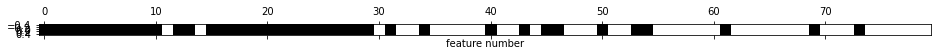

In [18]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('feature number')

In [19]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print(f'test score: {score}')

test score: 0.9473684210526315


### 반복적 특성 선택 (Iterative Feature Selection)
* 특성의 수가 각기 다른 일련의 모델이 만들어진다.
* 특성을 하나도 선택하지 않은 상태로 시작해서 어떤 종료 조건에 도달할 때까지 하나씩 추가하는 방법.
* 모든 특성을 가지고 시작해서 어떤 종료 조건이 될 때까지 특성을 하나씩 제거해가는 방법. (채귀적 특성 제거 - RFE, recursive feature elimination)
* 계산 비용이 훨씬 많이 든다.

Text(0.5, 0, 'feature number')

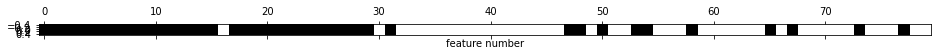

In [21]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('feature number')

In [22]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print(f'test score: {score}')

test score: 0.9403508771929825


In [23]:
print(f'test score: {select.score(X_test, y_test)}')

test score: 0.9508771929824561
